In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm
from tensorflow.keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd "/content/drive/MyDrive/reorganized/"

/content/drive/MyDrive/reorganized


In [4]:
!ls

akiec  bcc  bkl  df  mel  nv  vasc


In [10]:
print(cv2.imread('./df/ISIC_0024845.jpg').shape)

(450, 600, 3)


In [ ]:
# batch_size help us to load the dataset in batches when run the training process
batch_size = 4
train_dataset = tf.keras.preprocessing.image_dataset_from_directory('df', label_mode=None, image_size=(128,128), batch_size=batch_size)
train_dataset = train_dataset.map(lambda x: (x/127.5)-1)  # all the RGB pixel values would range between -1 to 1

Found 115 files belonging to 1 classes.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


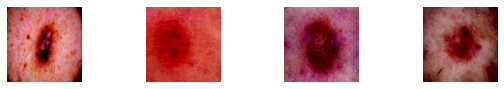

In [ ]:
# extract 1st 4 dataset from our 1st batch
plt.figure(figsize=(12,8))
for images in train_dataset.take(1):
  for i in range(4):
    ax=plt.subplot(5,5,i+1)
    plt.imshow(images[i].numpy())
    plt.axis('off')

In [ ]:
train_dataset

<MapDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>

Image Shape (128, 128, 3)


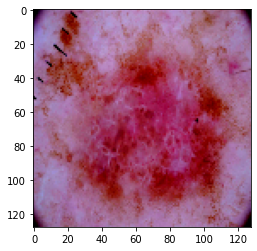

In [ ]:
for batch in train_dataset:
  plt.imshow(batch[0])
  print('Image Shape', batch[0].shape)
  break

In [ ]:
init_weights_kernel = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [ ]:
# Generator Model
def generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Input(shape=(100, )))
  model.add(layers.Dense(4 * 4 * 256))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Reshape((4,4,256)))  

  model.add(layers.Conv2DTranspose(128, kernel_size=4, padding='same', strides=2, kernel_initializer = init_weights_kernel, use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(64, kernel_size=4, padding='same', strides=2, kernel_initializer = init_weights_kernel, use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU()) 
  
  model.add(layers.Conv2DTranspose(32, kernel_size=4, padding='same', strides=2, kernel_initializer = init_weights_kernel, use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())     

  model.add(layers.Conv2DTranspose(32, kernel_size=4, padding='same', strides=2, kernel_initializer = init_weights_kernel, use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())    
  
  model.add(layers.Conv2DTranspose(3, kernel_size=4, padding='same', strides=2, activation = 'tanh', kernel_initializer = init_weights_kernel, use_bias=False))

  return model

In [ ]:
generator = generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              413696    
                                                                 
 batch_normalization_8 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 re_lu_5 (ReLU)              (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 8, 8, 128)        524288    
 ranspose)                                                       
                                                                 
 batch_normalization_9 (Batc  (None, 8, 8, 128)       

(1, 128, 128, 3)


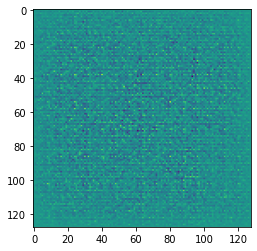

In [ ]:
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0,:,:,0]*255*100) # This image is just the noise

In [ ]:
generated_image[0,:5,:5]

<tf.Tensor: shape=(5, 5, 3), dtype=float32, numpy=
array([[[ 2.38512735e-06,  1.64205403e-06,  1.03116272e-05],
        [-7.66804806e-06,  4.45710475e-06,  2.78094813e-05],
        [-7.24460187e-06, -1.35655991e-05,  1.89610437e-05],
        [-3.42746098e-05,  4.62995195e-06, -1.21008507e-05],
        [ 2.35782863e-05, -1.14987233e-06,  2.68226522e-05]],

       [[ 1.22955662e-05, -1.06629159e-08, -3.41946834e-05],
        [-4.77905305e-05, -2.52757418e-05,  1.94900367e-05],
        [-9.06929199e-05,  2.19535104e-05, -3.87921355e-05],
        [-5.83564834e-05,  5.87364957e-05,  3.71509741e-05],
        [-1.41704950e-04, -5.65147275e-06, -3.75801137e-05]],

       [[-1.61904723e-06, -2.89802010e-05,  3.11748190e-05],
        [-1.20268214e-06,  3.68828223e-05,  4.46346712e-05],
        [ 2.76724495e-06, -2.51942456e-05,  1.16734212e-04],
        [-4.97341098e-05, -2.57349529e-05,  5.70783595e-05],
        [ 9.45048378e-05, -1.33836456e-05,  1.00408201e-04]],

       [[-7.12808014e-06,  2

In [ ]:
# DISCRIMINATOR MODEL
def discriminator_model():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(32,kernel_size=3, strides=2, input_shape=(128,128,3), padding='same', kernel_initializer = init_weights_kernel, use_bias=False))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(32,kernel_size=3, strides=2, padding='same', kernel_initializer = init_weights_kernel, use_bias=False))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(64,kernel_size=3, strides=2, padding='same', kernel_initializer = init_weights_kernel, use_bias=False))
  model.add(layers.ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(128,kernel_size=3, strides=2, padding='same', kernel_initializer = init_weights_kernel, use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(256,kernel_size=3, strides=1, padding='same', kernel_initializer = init_weights_kernel, use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.3))


  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
  
  return model

In [ ]:
discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        864       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        9216      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 dropout_6 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)       

In [ ]:
output = discriminator(generated_image)
print(output)

tf.Tensor([[0.5]], shape=(1, 1), dtype=float32)


In [ ]:
bce = tf.keras.losses.BinaryCrossentropy()

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = bce(tf.ones_like(real_output), real_output) 
  fake_loss = bce(tf.zeros_like(fake_output), fake_output) 
  total_loss = real_loss + fake_loss 
  return total_loss

In [ ]:
def generator_loss(fake_output):
  gen_loss = bce(tf.ones_like(fake_output), fake_output)
  return gen_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [ ]:

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer, 
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [ ]:
epochs = 160
noise_dim = 100
num_examples_to_generate = 16 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
def generate_and_plot_images(model, epoch , test_input):
  predictions = model(test_input, training = False)

  fig = plt.figure(figsize=(8,4))
  for i in range(predictions.shape[0]):
    plt.subplot(4,4, i+1)
    plt.imshow((predictions[i, :, :, :] * 0.5 + 0.5))
    plt.axis('off')

  #plt.savefig('image_at_epch_{:04d}.png'.format(epoch))
  plt.show()

# This will allow us to see how the generator improves over time.

In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([batch_size, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)
    
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)    

  gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradient_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradient_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

  return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))


In [ ]:
def train(dataset, epochs):
  
  # list used for plotting
  gen_loss_list = [] 
  disc_loss_list = []

  # list used for accuracies score for the discriminator on real and fake data
  real_score_list = []
  fake_score_list = []

  # run for no. of epochs
  # for every epoch we'll split our real training dataset into batches and feed
  # in this data one batch at a time
  for epoch in tqdm(range(epochs)):
    start = time.time()
    num_batches = len(dataset)

    print(f'Training started with epoch {epoch + 1} with {num_batches} batches...')

    # Variables for total generator loss and the total discriminator loss
    total_gen_loss = 0
    total_disc_loss = 0

    # for every batch of the i/p data, the train_step will train the generator and the discriminator
    # on this batch of data.
    # The train_step function - generates fake images, feeds real as well as fake images to the 
    # discriminator, computes loss, computes gradients for both of our adversary N/W, and updates
    # both the model parameters
    for batch in dataset:
      generator_loss, discriminator_loss, real_score, fake_score = train_step(batch)
      total_gen_loss += generator_loss
      total_disc_loss += discriminator_loss

    # Computer the average loss of the epoch, this mean values will be print out on screen
    mean_gen_loss = total_gen_loss / num_batches
    mean_disc_loss = total_disc_loss / num_batches

    print('Losses after epoch %5d: generator %.3f, discriminator %.3f, real_score %.2f%%, fake_score %.2f%%' %
          (epoch + 1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))
    
    # generate_and_plot_images function is invokes to feed in our test noise sample, i.e. seed
    # That is our seed and see what is the o/p looks like after the current epoch of training
    # It saves the images after each epoch
    ################################################################################################
    generate_and_plot_images(generator, epoch + 1, seed)

    gen_loss_list.append(mean_gen_loss)
    disc_loss_list.append(mean_disc_loss)
    real_score_list.append(real_score)
    fake_score_list.append(fake_score)

    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  return gen_loss_list, disc_loss_list, real_score_list, fake_score_list

In [ ]:
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(train_dataset, epochs=epochs)

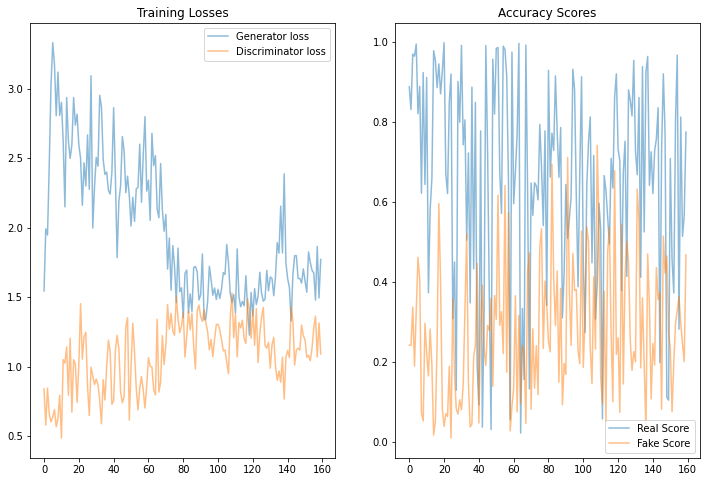

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))

ax1.plot(gen_loss_epochs, label = 'Generator loss', alpha=0.5)
ax1.plot(disc_loss_epochs, label = 'Discriminator loss', alpha=0.5)
ax1.legend()

ax1.set_title('Training Losses')
ax2.plot(real_score_list, label = 'Real Score', alpha = 0.5)
ax2.plot(fake_score_list, label = 'Fake Score', alpha = 0.5)
ax2.set_title('Accuracy Scores')

ax2.legend()

# Prediction

(1, 128, 128, 3)


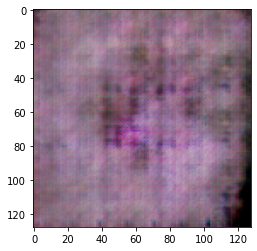

In [ ]:
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, :] * 0.5 + 0.3) 


# Saving Images for the Generator

In [ ]:
!mkdir "saved_df_images"
directory = "/content/drive/MyDrive/reorganized/saved_df_images/"
os.chdir(directory)
!ls

In [ ]:
# Print the list of files in the directory before saving the image
print("Before saving")   
print(os.listdir(directory))  

Before saving
[]


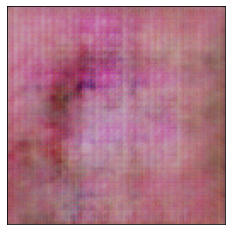

In [ ]:
for i in range(50):
  generated_image = generator(tf.random.normal([1,100]), training=False)
  generated_image = generated_image[0, :, :, :] * 0.5 + 0.3
  plt.imshow(generated_image)
  plt.xticks([])
  plt.yticks([])
  plt.savefig(str(i)+".png")
  #cv2.imwrite(str(i)+".png",generated_image)

In [ ]:
print("After saving")  
print(os.listdir(directory))

After saving
['50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65.png', '66.png', '67.png', '68.png', '69.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '80.png', '81.png', '82.png', '83.png', '84.png', '85.png', '86.png', '87.png', '88.png', '89.png', '90.png', '91.png', '92.png', '93.png', '94.png', '95.png', '96.png', '97.png', '98.png', '99.png']


In [ ]:
!pwd

/content/drive/MyDrive/reorganized/saved_df_images


# Inception Score

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os.path
import sys
import tarfile

import numpy as np
from six.moves import urllib
import tensorflow as tf
import glob
import scipy.misc
import math
import sys
import cv2

In [ ]:
filenames = glob.glob(os.path.join(directory, '*.*'))
images = [cv2.imread(filename) for filename in filenames]

In [ ]:
images[0].shape

(288, 432, 3)

In [ ]:
images = np.stack(images, axis=0)

In [ ]:
images.shape

(50, 288, 432, 3)

In [ ]:
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray
 
# scale an array of images to a new size
def scale_images(images, new_shape):
  images_list = list()
  for image in images:
    # resize with nearest neighbor interpolation
    new_image = resize(image, new_shape, 0)
    # store
    images_list.append(new_image)
  return asarray(images_list)
 
# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
  # load inception v3 model
  model = InceptionV3()
  # enumerate splits of images/predictions
  scores = list()
  n_part = floor(images.shape[0] / n_split)
  for i in range(n_split):
    # retrieve images
    ix_start, ix_end = i * n_part, (i+1) * n_part
    subset = images[ix_start:ix_end]
    # convert from uint8 to float32
    subset = subset.astype('float32')
    # scale images to the required size
    subset = scale_images(subset, (299,299,3))
    # pre-process images, scale to [-1,1]
    subset = preprocess_input(subset)
    # predict p(y|x)
    p_yx = model.predict(subset)
    # calculate p(y)
    p_y = expand_dims(p_yx.mean(axis=0), 0)
    # calculate KL divergence using log probabilities
    kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
    # sum over classes
    sum_kl_d = kl_d.sum(axis=1)
    # average over images
    avg_kl_d = mean(sum_kl_d)
    # undo the log
    is_score = exp(avg_kl_d)
    # store
    scores.append(is_score)
  # average across images
  is_avg, is_std = mean(scores), std(scores)
  return is_avg, is_std
 
###############  LOAD ALL IMAGES ############
# shuffle images
shuffle(images)
print('loaded', images.shape)
# calculate inception score
is_avg, is_std = calculate_inception_score(images)
print('score', is_avg, is_std)

loaded (50, 288, 432, 3)
1/1 [==============================] - 0s 36ms/step
score 1.2168045 0.05918236
